In [490]:
import os
import json
import pandas as pd
import numpy as np
import itertools
from turing.features import nlp
from turing.features.common import desctiptive_stats
from turing.features.freq import top_words, top_lemmas, word_counts, lemma_counts, freq_idx_lemmas
import xgboost as xgb
from scipy.stats import spearmanr
from random import shuffle, randint
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
plt.rcParams["figure.figsize"] = (30,15)
import math

from collections import defaultdict, Counter
from sklearn.metrics import roc_auc_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel, polynomial_kernel, rbf_kernel, chi2_kernel, additive_chi2_kernel, manhattan_distances

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [475]:
doc = json.load(open("../../turing-data/train_20170724.json"))
doc2 = json.load(open("../../turing-data/train_20170725.json"))
doc3 = json.load(open("../../turing-data/train_20170726.json"))
doc4 = json.load(open("../../turing-data/train_20170727.json"))

tdoc = json.load(open("../../turing-data/test_20170727.json"))

clf1 = json.load(open("data/p/clf_train_20170724.json"))
clf2 = json.load(open("data/p/clf_train_20170725.json"))
clf3 = json.load(open("data/p/clf_train_20170726.json"))

p_train = pd.DataFrame.from_csv("data/p2/eval_t.csv")
p_test = pd.DataFrame.from_csv("data/p2/all_own_test.csv")

p = pd.concat([p_train, p_test])

diags = doc + doc2 + doc3 + doc4

In [459]:
tdoc[1]

{u'context': u'In the James Bond series by Ian Fleming, James Bond, reads The Times. As described by Fleming in From Russia, with Love: "The Times was the only paper that Bond ever read."',
 u'dialogId': 319946573,
 u'thread': [{u'text': u'Hi', u'time': 567000000, u'userId': u'Alice'},
  {u'text': u'good day to you! how are you?',
   u'time': 567000000,
   u'userId': u'Bob'},
  {u'text': u'Great. Have you seen any of James Bond movies?',
   u'time': 567000000,
   u'userId': u'Alice'},
  {u'text': u'The Times', u'time': 567000000, u'userId': u'Bob'},
  {u'text': u'That is newspaper', u'time': 567000000, u'userId': u'Alice'},
  {u'text': u'what is a " r noshitsherlock "?',
   u'time': 567000000,
   u'userId': u'Bob'},
  {u'text': u"I don't know", u'time': 567000000, u'userId': u'Alice'},
  {u'text': u"i'm a bot, and i'm not even a bot .",
   u'time': 567000000,
   u'userId': u'Bob'},
  {u'text': u'Well, sorry to hear that',
   u'time': 567000000,
   u'userId': u'Alice'}],
 u'users': [{u'

In [460]:
def is_bot(diag, user):
    text = " ".join([x["text"] for x in diag["thread"] if x["userId"] == user])
    
    if len(text) == 0:
        return False
    
    if "avilable" in text:
        return True
    
    if "Hint: first" in text:
        return True
    
    if " ." in text or " ," in text or " '" in text:
        return True
    
    if "\n" in text:
        return True
    
    if ">" in text:
        return True
    
    return False

In [461]:
def get_score(diag, user):
    return filter(lambda x: x["userId"] == user, diag["evaluation"])[0]["quality"]

In [462]:
# def correlation_old(diags, bst):
#     df = make_features(diags, True)
    
#     label_column = df["label"]
#     features = df.drop(["label", "dialogId", "user"], axis=1)
#     dtest = xgb.DMatrix(features.values, feature_names=features.columns)
    
#     preds = bst.predict(dtest)
    
#     for i, diag in enumerate(diags):
#         for j, name in enumerate(["Alice","Bob"]):
#             if is_bot(diag, name):
#                 preds[2*i+j] = 0

#     df["prediction"] = preds
    
# #     print df[["label","prediction"]]
    
#     return spearmanr(df["label"].values, df["prediction"].values)

In [463]:
def correlation(test_diags, test_set, bst, rules = True):
    label_column = test_set["label"]
    features = test_set.drop(["label", "dialogId", "user"], axis=1)
    dtest = xgb.DMatrix(features.values, feature_names=features.columns)
    
    preds = bst.predict(dtest)

    if rules:
        for i, diag in enumerate(test_diags):
            for j, name in enumerate(["Alice","Bob"]):
                if is_bot(diag, name):
                    preds[2*i+j] = 0
    
    return spearmanr(test_set["label"].values, preds)

In [464]:
def cv(diags, test_ratio=0.2, folds=5, params=None, **kwargs):
    scores = []
    df_feats = make_features(diags, True)
    
    for i in range(0,len(diags),len(diags)/folds)[:-1]:
        test_set = df_feats[2*i:2*i+2*int(test_ratio*len(diags))]
        test_diags = diags[i:i+int(test_ratio*len(diags))]
        train_set = pd.concat([df_feats[0:2*i],df_feats[2*i+2*int(test_ratio*len(diags)):]])
        
        label_column = train_set["label"]
        features = train_set.drop(["label", "dialogId", "user"], axis=1)

        dtrain = xgb.DMatrix(features.values, label_column.values, feature_names=features.columns)
        bst = xgb.train(param, dtrain, num_boost_round=50)
        
        scores.append(correlation(test_diags, test_set, bst, **kwargs).correlation)
        print scores[-1]
        
    return np.mean(scores)

In [477]:
def flatten_dialogs(diags):
    res = []
    for d in diags:
        for t in d["thread"]:
            if len(t["text"].strip(" *")) > 10 and "\n" not in t["text"]:
                res.append((d["dialogId"],t["userId"],t["text"].encode("utf-8")))
    
    return pd.DataFrame.from_records(res, columns=["dialogId","userId","text"])

In [478]:
df_texts = flatten_dialogs(diags)
df_texts.to_csv("data/texts", sep="\t",encoding="utf-8")

In [480]:
ppl_df = pd.DataFrame.from_csv("data/ppl_scores", index_col=0).reset_index()
ppl_df_big = pd.concat([df_texts,ppl_df],axis=1)

In [398]:
def make_submit(test_diags, train_diags):
    train_set = make_features(train_diags,True)
    test_set = make_features(test_diags,False)
    
    label_column = train_set["label"]
    train_features = train_set.drop(["label", "dialogId", "user"], axis=1)
    
    test_features = test_set.drop(["dialogId", "user"], axis=1)
    
    dtrain = xgb.DMatrix(train_features.values, label_column.values, feature_names=train_features.columns)
    dtest = xgb.DMatrix(test_features.values, feature_names=test_features.columns)
    
    bst = xgb.train(param, dtrain, num_boost_round=150)
    preds = bst.predict(dtest)
    

    for i, diag in enumerate(tdoc):
        for j, name in enumerate(["Alice","Bob"]):
            if is_bot(diag, name):
                preds[2*i+j] = 0

    test_set["prediction"] = preds
    
    
    scores = defaultdict(dict)
    for i in range(0,len(test_set)):
        row = test_set.iloc[i]
        scores[row["dialogId"]][row["user"]] = row["prediction"]
        
    records = []
    for dialog_id in scores:
        records.append((dialog_id,scores[dialog_id]["Alice"],scores[dialog_id]["Bob"]))
    
    return pd.DataFrame.from_records(records, columns=["dialogId","Alice","Bob"])

In [401]:
submit = make_submit(tdoc, diags)

In [402]:
submit.to_csv("submit27allfeats.csv", index=False)

In [30]:
tdoc[0]

{u'context': u'In 1938 the Nazis altered about one-third of the toponyms of the area, eliminating, Germanizing, or simplifying a number of Old Prussian names, as well as those Polish or Lithuanian names originating from colonists and refugees to Prussia during and after the Protestant Reformation. More than 1,500 places were ordered to be renamed by 16 July 1938 following a decree issued by Gauleiter and Oberpr\xe4sident Erich Koch and initiated by Adolf Hitler. Many who would not cooperate with the rulers of Nazi Germany were sent to concentration camps and held prisoner there until their death or liberation.',
 u'dialogId': 1356952707,
 u'thread': [{u'text': u'Hello, my friend. Hope this chat will go well. I will ask you a question in a second, please wait',
   u'time': 269000000,
   u'userId': u'Bob'},
  {u'text': u'What was the number of prussian names in 1938?',
   u'time': 269000000,
   u'userId': u'Bob'},
  {u'text': u'100?', u'time': 269000000, u'userId': u'Alice'},
  {u'text':

# Features

In [482]:
# df = flatten_dialogs(diags)
# df.to_csv("data/texts", sep="\t",encoding="utf-8")
# ppl_df = pd.DataFrame.from_csv("data/ppl_scores", index_col=0).reset_index()
# ppl_df = pd.concat([df,ppl_df], axis=1)

def ngram_ppl(diag, user):
    res = pd.Series()
    
    res["self_ngram_logprob2"] = np.mean(ppl_df_big[ppl_df_big.dialogId == diag["dialogId"]][ppl_df_big.userId == user]["logprob"])
    res["self_ngram_ppl"] = np.mean(ppl_df_big[ppl_df_big.dialogId == diag["dialogId"]][ppl_df_big.userId == user]["ppl"])
    res["other_ngram_logprob"] = np.mean(ppl_df_big[ppl_df_big.dialogId == diag["dialogId"]][ppl_df_big.userId != user]["logprob"])
    res["other_ngram_ppl"] = np.mean(ppl_df_big[ppl_df_big.dialogId == diag["dialogId"]][ppl_df_big.userId != user]["ppl"])

    
    return res

In [483]:
def lengths(diag, user):
    res = pd.Series()
    self_thread = filter(lambda x: x["userId"] == user, diag["thread"])
    other_thread = filter(lambda x: x["userId"] != user, diag["thread"])
    res["self_phrases_cnt"] = len(self_thread)
    res["other_phrases_cnt"] = len(other_thread)
    
    res["self_words_cnt"] = len([w for s in self_thread for w in s])
    res["other_words_cnt"] = len([w for s in other_thread for w in s])
    
    res["self_avg_words"] = 0 if res["self_phrases_cnt"] == 0 else float(res["self_words_cnt"])/res["self_phrases_cnt"] 
    res["other_avg_words"] = 0 if res["other_phrases_cnt"] == 0 else float(res["other_words_cnt"])/res["other_phrases_cnt"]
    
    return res

In [484]:
def context_similarity(diag, user):
    context_vector = np.mean([
        word.vector for word in nlp(diag["context"])
    ], axis=0).reshape((1,-1))
    
    self_thread = filter(lambda x: x["userId"] == user, diag["thread"])
    other_thread = filter(lambda x: x["userId"] != user, diag["thread"])
    
    try:
        self_vector = np.mean([
                word.vector for word in nlp(unicode(self_thread[0]["text"]))
            ],axis=0).reshape((1,-1))

        other_vector = np.mean([
                word.vector for word in nlp(unicode(other_thread[0]["text"]))
            ],axis=0).reshape((1,-1))

        res = pd.Series()

        res["self_context_cosine"] = 0 if not self_thread else cosine_similarity(self_vector, context_vector).flatten()[0]
        res["other_context_cosine"] = 0 if not other_thread else cosine_similarity(other_vector, context_vector).flatten()[0]
        return res
    except:
        return pd.Series()

In [485]:
def w2v(diag, user):
    self_thread = filter(lambda x: x["userId"] == user, diag["thread"])
    other_thread = filter(lambda x: x["userId"] != user, diag["thread"])
    
    try:
        self_vector = np.mean([
                word.vector for word in nlp(unicode(" ".join([x["text"] for x in self_thread])))
            ],axis=0)

        other_vector = np.mean([
                word.vector for word in nlp(unicode(" ".join([x["text"] for x in other_thread])))
            ],axis=0)
        
        self_ser = pd.Series(data=self_vector, index=["self_w2v_{}".format(i) for i in range(0, self_vector.shape[0])])
        other_ser = pd.Series(data=other_vector, index=["other_w2v_{}".format(i) for i in range(0, other_vector.shape[0])])
        return self_ser.append(other_ser)
    except:
        return pd.Series()

In [492]:
def freq_stat(diag, user):

    def topN_count(parsed_text):
        return len(filter(lambda x: x.orth_.lower() in top_words, parsed_text))

    def topN_count_lemma(parsed_text):
        return len(filter(lambda x: x.lemma_ in top_lemmas, parsed_text))

    def no_vocab_tokens(parsed_text):
        return len(filter(lambda x: x.lemma_ not in lemma_counts, parsed_text))

    def avg_index_lemma(parsed_text):
        freqs = [freq_idx_lemmas.get(token.lemma_, None) for token in parsed_text]
        logs = [math.log(x) for x in filter(lambda x: x, freqs)]
        if logs:
            return np.mean(logs)
        else:
            return None

    res = pd.Series()
    self_thread = [nlp(unicode(x)) for x in filter(lambda x: x["userId"] == user, diag["thread"])]
    other_thread = [nlp(unicode(x)) for x in filter(lambda x: x["userId"] != user, diag["thread"])]
    
    res["self_topN_count"] = np.mean([
        topN_count(x) for x in self_thread
    ])
    res["other_topN_count"] = np.mean([
        topN_count(x) for x in other_thread
    ])
    
    res["self_no_vocab_tokens"] = np.mean([
        no_vocab_tokens(x) for x in self_thread
    ])
    res["other_no_vocab_tokens"] = np.mean([
        no_vocab_tokens(x) for x in other_thread
    ])
    
    avg_idx_self = filter(lambda x: x, [avg_index_lemma(x) for x in self_thread])
    avg_idx_other = filter(lambda x: x, [avg_index_lemma(x) for x in other_thread])
    
    if avg_idx_self:
        res["self_avg_index_lemma"] = np.mean(avg_idx_self)
    
    if avg_idx_other:
        res["other_avg_index_lemma"] = np.mean(avg_idx_other)
    
    return res

In [493]:
def make_features(diags,labeled=False):
    observations = []
    for d in diags:
        for name in ("Bob","Alice"):
            obs = freq_stat(d,name)\
            .append(lengths(d,name))\
            .append(context_similarity(d,name))\
            .append(w2v(d,name))\
            .append(ngram_ppl(d,name))
            
            obs["user"] = name
            obs["dialogId"] = d["dialogId"]
            
            if labeled:
                obs["label"] = get_score(d,name)
            
            observations.append(obs)
    
    return pd.DataFrame(observations)

In [494]:
param = {'eta':0.1, 'max_depth':3, 'min_child_weight':1, 'gamma':0.1,
         'silent':0, 'subsample':0.9, 'colsample_bytree': 0.8,  
         'objective':'reg:linear'}

In [497]:
shuffle(diags)
cv(diags, folds=20, params=param, rules=True)

0.720966229364
0.695735210434
0.694774989687
0.697692729612
0.67940373341
0.673450547869
0.6836551532
0.676093539431
0.696277380179
0.710485357809
0.689039403131
0.695578607007
0.693616789371
0.694915664877
0.701172729441
0.687926255335
0.689023741598
0.688539546356
0.708314376243
0.687743363814


0.69322026740842302

In [258]:
shuffle(diags)
cv(diags, folds=20, params=param, rules=True)

0.733606526175
0.727650414431
0.690177080335
0.680526426707
0.696951028986
0.678523957793
0.708113543803
0.728394409003
0.689824227423
0.661290742352
0.667980984215
0.682381032084
0.701258518923
0.730501141466
0.712763256767
0.69097417567
0.692214029374
0.680138468018
0.700251248919
0.700476422775


0.69769988176087883

In [133]:
syntax_stats(diags[3],"Bob")

Series([], dtype: float64)

In [185]:
is_bot_pasha(diags[10],"Alice")

True

In [186]:
diags[10]["dialogId"]

2107312123

## Weighted sum

In [495]:
all_features = make_features(diags, True)

In [410]:
train_dialogs = list(set(all_features["dialogId"]) & set(p_train["dialog_id"]))
test_dialogs = list(set(all_features["dialogId"]) & set(p_test["dialog_id"]))

In [411]:
train_set = pd.merge(all_features[all_features.dialogId.isin(train_dialogs)], p_train, how="inner",  left_on=["dialogId","user","label"], right_on=["dialog_id","user","label"])
test_set = pd.merge(all_features[all_features.dialogId.isin(test_dialogs)], p_test, how="inner",  left_on=["dialogId","user","label"], right_on=["dialog_id","user","label"])

In [414]:
to_drop = ["is_bot_other"]
# to_drop = ["score","is_bot","is_bot_other","score_other"]

label_column = train_set["label"]
features = train_set.drop(["label", "dialogId", "user", "dialog_id","is_bot_real"] + to_drop , axis=1)

dtrain = xgb.DMatrix(features.values, label_column.values, feature_names=features.columns)
bstP = xgb.train(param, dtrain, num_boost_round=120)

In [369]:
test_dialogs_content = filter(lambda x: x["dialogId"] in test_dialogs, diags)
train_dialogs_content = filter(lambda x: x["dialogId"] in train_dialogs, diags)
test_set = test_set.drop(["dialog_id","is_bot_real"] + to_drop,axis=1)
train_set = train_set.drop(["dialog_id","is_bot_real"] + to_drop,axis=1)

In [371]:
correlation(test_dialogs_content, test_set, bst, rules=True)

SpearmanrResult(correlation=0.69777021319249433, pvalue=2.938695598372428e-105)

In [274]:
correlation(test_dialogs_content, test_set, bst, rules=False)

SpearmanrResult(correlation=0.72582463986932766, pvalue=6.412737632862228e-113)

## Weighted sum

In [682]:
features = test_set.drop(["label","user","dialogId","mypred"], axis=1)
dtest = xgb.DMatrix(features.values, feature_names=features.columns)

my_preds = bst.predict(dtest)
test_set["mypred"] = my_preds

for coeff in (0, 0.1, 0.3, 0.5, 0.8, 1, 2, 5, 10, 100):
    print coeff, spearmanr(test_set["label"], [m+p*coeff for m,p in zip(my_preds,pasha_scores.fillna(0))])

0 SpearmanrResult(correlation=0.6601754021835986, pvalue=6.360148932045275e-43)
0.1 SpearmanrResult(correlation=0.65103355812147701, pvalue=2.0702300792624811e-41)
0.3 SpearmanrResult(correlation=0.62875059100712005, pvalue=6.2052056208790026e-38)
0.5 SpearmanrResult(correlation=0.59875232324472594, pvalue=1.1213995961561921e-33)
0.8 SpearmanrResult(correlation=0.56768666937357892, pvalue=1.0235020159929194e-29)
1 SpearmanrResult(correlation=0.54864398151793592, pvalue=1.7288737621821692e-27)
2 SpearmanrResult(correlation=0.49271681279629653, pvalue=1.0432057112298769e-21)
5 SpearmanrResult(correlation=0.44172143286990401, pvalue=2.7402978604859894e-17)
10 SpearmanrResult(correlation=0.42078141663164603, pvalue=1.1179574248581537e-15)
100 SpearmanrResult(correlation=0.39886324803684026, pvalue=4.1531643090352476e-14)


In [496]:
all_features.to_csv("all_features.csv")

In [252]:
context_similarity(diags[2],"Alice")

self_context_cosine     0.912949
other_context_cosine    0.244651
dtype: float64

## Pasha submit

In [428]:
evalp = pd.DataFrame.from_csv("data/p2/eval.csv")
my_features_eval = make_features(tdoc,False)

In [429]:
test_set_eval = pd.merge(my_features_eval, evalp, how="inner",  left_on=["dialogId","user"], right_on=["dialog_id","user"])

In [432]:
test_set_eval_feats = test_set_eval.drop(["label", "dialogId", "user", "dialog_id","is_bot_real"] + to_drop, axis=1)
dtest = xgb.DMatrix(test_set_eval_feats.values, feature_names=test_set_eval_feats.columns)
preds = bst.predict(dtest)

In [433]:
len(preds)

930

In [359]:
spearmanr(preds,my_features_eval["label"])

SpearmanrResult(correlation=0.90274240878359735, pvalue=6.5730908946472349e-203)

In [434]:
test_set_eval["prediction"] = preds


scores = defaultdict(dict)
for i in range(0,len(test_set_eval)):
    row = test_set_eval.iloc[i]
    scores[row["dialogId"]][row["user"]] = row["prediction"]

records = []
for dialog_id in scores:
    records.append((dialog_id,scores[dialog_id]["Alice"],scores[dialog_id]["Bob"]))

res = pd.DataFrame.from_records(records, columns=["dialogId","Alice","Bob"])

In [435]:
res.to_csv("submit27PP.csv", index=False)

In [335]:
len(train_set_eval), len(all_features), len(p)

(1716, 1716, 1716)

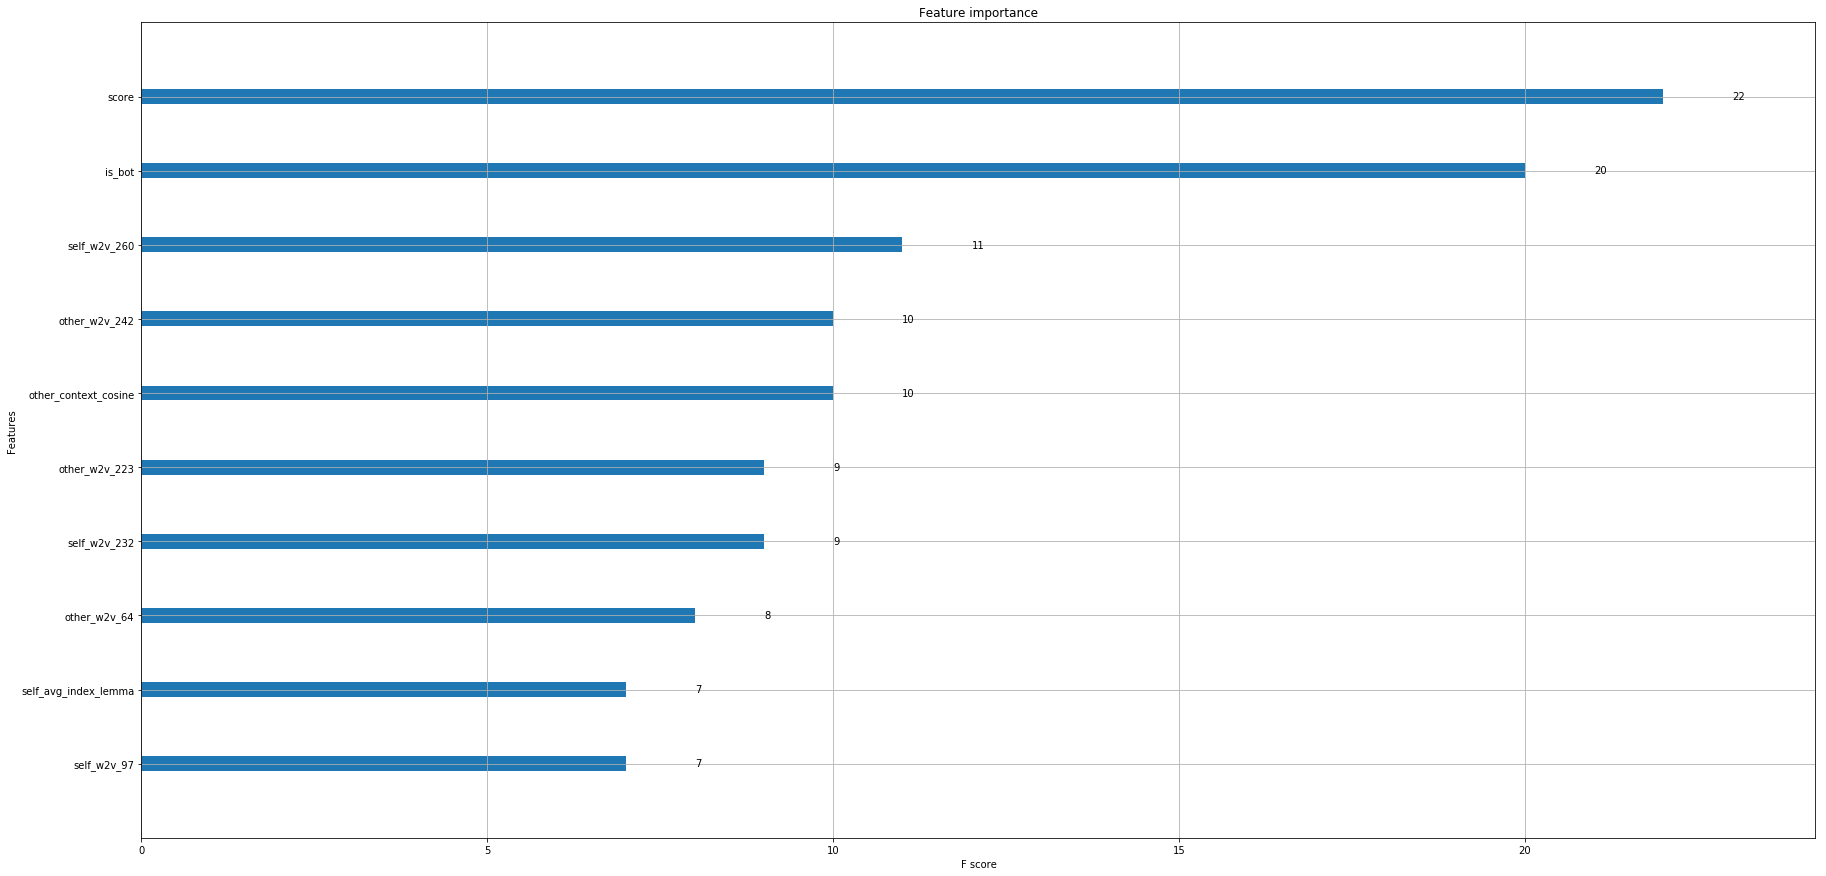

In [445]:
xgb.plot_importance(bst, max_num_features=10)

In [442]:
good_submit = pd.DataFrame.from_csv("submit27rules.csv")
bad_submit = pd.DataFrame.from_csv("submit27P.csv")

In [443]:
print "to good", spearmanr(res["Alice"],good_submit["Alice"]), spearmanr(res["Bob"],good_submit["Bob"])
print "to bad", spearmanr(res["Alice"],bad_submit["Alice"]), spearmanr(res["Bob"],bad_submit["Bob"])

to good SpearmanrResult(correlation=0.75120204037181526, pvalue=1.456533986435211e-85) SpearmanrResult(correlation=0.69738497599953286, pvalue=5.5559833623030811e-69)
to bad SpearmanrResult(correlation=0.59609552564356549, pvalue=4.5036265845058551e-46) SpearmanrResult(correlation=0.58935831072688438, pvalue=7.8766575853833381e-45)


In [468]:
lesha_df = pd.DataFrame.from_csv("all_predictions_lesha.csv").reset_index()

In [471]:
def df_to_submit(df):
    scores = defaultdict(dict)
    for i in range(0,len(df)):
        row = df.iloc[i]
        scores[row["dialogId"]][row["user"]] = row["prediction"]
        
    records = []
    for dialog_id in scores:
        records.append((dialog_id,scores[dialog_id]["Alice"],scores[dialog_id]["Bob"]))
    
    return pd.DataFrame.from_records(records, columns=["dialogId","Alice","Bob"])

In [472]:
res = df_to_submit(lesha_df)

In [452]:
res.to_csv("submit_q_minus.csv",index=False)

In [456]:
all_features.to_csv("all_feats_27.csv", index=False)

In [473]:
res.to_csv("lesha_submit.csv",index=False)

In [501]:
json.dump(tdoc[:30], open("tdoc.json","w"))